In [1]:
import sys
sys.path.insert(0, '../gofher')

import numpy as np
import csv

import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from gofher import run_gofher
from galaxy import galaxy
from matrix import create_centered_mesh_grid
from visualize import visualize
from fits import write_fits
from file_helper import write_csv,check_if_folder_exists_and_create
from spin_parity import read_spin_parity_galaxies_label_from_csv, standardize_galaxy_name

In [2]:
survery_to_use = "panstarrs"

BANDS_IN_ORDER = ['g','r','i','z','y'] #Important: Must stay in order of BLUEST to REDDEST Waveband (Editting this will cause gofher to no longer correctly evaluate redder side of galaxy)
REF_BANDS_IN_ORDER = ['i','z','y','r','g'] #The prefernce each waveband being choosen as refernce band from highest priority to lowest priority

In [3]:
figure_to_run_on = "figure10"

In [4]:
generate_verbose_csv = False
generate_ebm_csv = False
generate_visualization = True
save_visualization = False

In [5]:
#Important: Make sure you update these values:
#path_to_catalog_data = "..\\..\\spin-parity-catalog-data"
path_to_catalog_data = "../../spin-parity-catalog-data"
#path_to_output = "..\\..\\gofher-data\\panstarrs\\source_extraction"

In [6]:
def get_fits_path(name,band):
    """the file path of where existing fits files can be found"""
    return os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on,name,"{}_{}.fits".format(name,band))

def get_color_image_path(name):
    return os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on,name,"{}_color.jfif".format(name))

def get_path_to_catalog_csv():
    return os.path.join(path_to_catalog_data,"catalog","{}.csv".format(figure_to_run_on))

In [7]:
def get_paper_dark_side_labels():
    return read_spin_parity_galaxies_label_from_csv(get_path_to_catalog_csv())

def get_galaxies():
    return os.listdir(os.path.join(path_to_catalog_data,survery_to_use,figure_to_run_on))

In [8]:
def generate_raw_csvs(gal,path_to_folder=''):
    output_pa = os.path.join(path_to_folder,gal.name)
    check_if_folder_exists_and_create(output_pa)
    
    pos,neg = gal.create_bisection()
    to_output = pos.astype(int) - neg.astype(int)
    to_output *= gal.area_to_diff

    write_fits(os.path.join(output_pa,"{}_raw.fits".format(gal.name)),to_output)

    to_write = []

    for band_pair_key in gal.band_pairs:
        band_pair = gal.band_pairs[band_pair_key]

        write_fits(os.path.join(output_pa,"{}_{}.fits".format(gal.name,band_pair_key)),band_pair.diff_image)

        p = np.logical_and(pos,gal.area_to_diff)
        n = np.logical_and(neg,gal.area_to_diff)
        
        to_write.append(["{}_{}".format(band_pair_key,gal.pos_side_label)] +list(band_pair.diff_image[p]))
        to_write.append(["{}_{}".format(band_pair_key,gal.neg_side_label)] +list(band_pair.diff_image[n]))

    with open(os.path.join(output_pa,"{}_raw.csv".format(gal.name)),'w',newline='') as f:
        writer = csv.writer(f)
        writer.writerows(to_write)

def generate_new_raw_csv(gal: galaxy,path_to_folder=''):
    h = gal.gofher_params.x; k = gal.gofher_params.y; shape = gal.area_to_diff.shape
    theta = gal.gofher_params.theta
    xv, yv = create_centered_mesh_grid(h,k,shape)

    el_maj_axis_pixel_coord = (xv*np.cos(theta)+yv*np.sin(theta))[gal.area_to_diff]
    el_min_axis_pixel_coord = (-xv*np.sin(theta)+yv*np.cos(theta))[gal.area_to_diff]
    data = gal.band_pairs['r-y'].diff_image[gal.area_to_diff]

    to_write = np.array([el_maj_axis_pixel_coord,el_min_axis_pixel_coord,data]).transpose()

    plt.imshow((xv*np.cos(theta)+yv*np.sin(theta))*gal.area_to_diff,origin='lower')
    plt.show()
    plt.imshow((-xv*np.sin(theta)+yv*np.cos(theta))*gal.area_to_diff,origin='lower')
    plt.show()

    #pa = os.path.join(path_to_folder,"{}_r-y.csv".format(gal.name))
    #print(pa)
    #np.savetxt(pa, to_write, delimiter=",")

In [9]:
def run_gofher_on_catalog(gals_to_run_on = []):
    paper_labels = get_paper_dark_side_labels()

    verbose_header = []
    verbose_rows = []

    ebm_header = []
    ebm_rows = []

    i = 1


    for name in get_galaxies():
        if len(gals_to_run_on) > 0 and name not in gals_to_run_on:
            continue

        if standardize_galaxy_name(name) not in paper_labels:
            print("skippimg",name)
            continue

        print(name, i,"of",len(get_galaxies()))

        #try:
        if True:
            paper_label = paper_labels[standardize_galaxy_name(name)]
            gal = run_gofher(name,get_fits_path,BANDS_IN_ORDER,REF_BANDS_IN_ORDER, paper_label)

            #pa = "/Users/cora-at-work/Desktop/raw_diff_output"
            pa = "C:\\Users\\school\\Desktop\\raw_diff_output"
            #generate_raw_csvs(gal,pa)
            generate_new_raw_csv(gal,pa)
        #except Exception as e:
        #print(e)
        i += 1


In [10]:
figure_10_gals = ["NGC3726"]
figure_9_gals = ["NGC3992",
                "NGC2525",
                "NGC628",
                "NGC278",
                "NGC3344",
                "NGC3346",
                "NGC3445",
                "NGC3642",
                "NGC4351",
                "NGC4490",
                "NGC4701",
                "NGC5218",
                "NGC5669",
                "NGC7549",
                "PGC06855",
                "PGC07826",
                "PGC20938",
                "PGC23913",
                "PGC27792",
                "PGC49906",
                "UGC10796",
                "UGC1081",
                "UGC12391",
                "UGC1529",
                "UGC1635",
                "UGC1908",
                "UGC312",
                "UGC3140",
                "UGC3997",
                "UGC4036",
                "UGC4458",
                "UGC448",
                "UGC4555",
                "UGC4622",
                "UGC463",
                "UGC4936",
                "UGC6903",
                "UGC6918",
                "UGC7244",
                "UGC8196",
                "UGC9965"]

additional_gals = ['NGC1']

NGC1 1 of 317


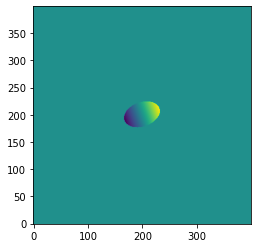

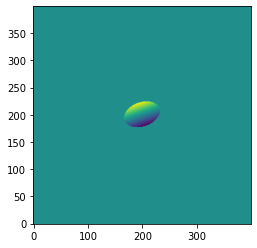

In [11]:
if not os.path.exists(path_to_catalog_data):
    raise ValueError("The path to the catalog is not found {} - make sure you update path_to_catalog_data".format(path_to_catalog_data))


run_gofher_on_catalog(additional_gals)
#generate_new_raw_csv(figure_10_gals)

In [122]:
pa = "C:\\Users\\school\\Desktop\\raw_diff_output\\raw_diff_output_csv\\NGC1_r-y.csv"

arr = np.loadtxt(pa,delimiter=",", dtype=str).transpose()

xs = arr[0].astype(float)
ys = arr[1].astype(float)
zs = arr[2].astype(float)

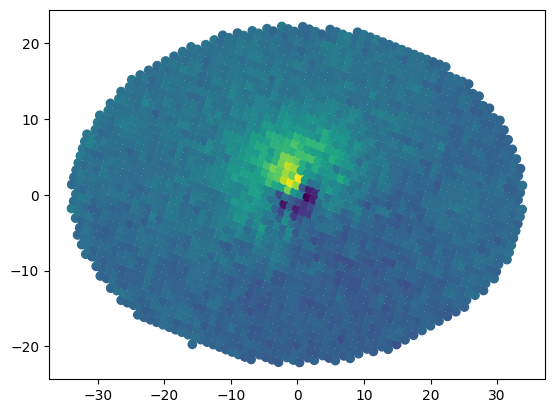

In [123]:
plt.scatter(xs,ys,c=zs)
plt.show()